In [2]:
!pip install pycuda

In [3]:
import time
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

In [4]:
def calculate_time(function):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = function(*args, **kwargs)
        end_time = time.time()

        return result, end_time - start_time

    return wrapper

class CPU_function():
  def get_g_value(self, x, y, sigma):
      exponent = np.exp(-((x**2) - (y**2)) / (2 * sigma**2))
      result = exponent / (2 * np.pi * sigma**2)
      return result

  def get_r_value(self, ai, a0, sigma):
      term = (ai - a0) ** 2
      term = np.clip(term, -50, 50)
      log_exponent = -term / (2 * sigma**2)
      log_result = log_exponent - 0.5 * np.log(2 * np.pi * sigma**2)
      return np.exp(log_result)

  def get_h_value(self, original_image, x, y, filter_size, sigma):
      delta = filter_size // 2
      x_start = x - delta
      x_end = x + delta
      y_start = y - delta
      y_end = y + delta
      k = 0

      summ = 0

      main_pixel_brightness = original_image[y, x]
      for y in range(y_start, y_end + 1):
          for x in range(x_start, x_end + 1):
              try:
                  current_pixel_brightness = original_image[y, x]
              except IndexError as e:
                  current_pixel_brightness = 0

              f = current_pixel_brightness
              g = self.get_g_value(x=abs(x - x_start), y=abs(y - y_start), sigma=sigma)
              r = self.get_r_value(
                  ai=current_pixel_brightness, a0=main_pixel_brightness, sigma=sigma
              )

              k += g * r
              summ += f * g * r

      if k == 0:
          return original_image[y, x]
      else:
          return summ / k

  @calculate_time
  def get_blurred_image(self, original_image, filter_size=7, sigma=10):
      height, width = original_image.shape
      blurred_image = np.zeros_like(original_image)

      for y in range(height):
          for x in range(width):
              new_brightness = self.get_h_value(original_image, x, y, filter_size, sigma)
              blurred_image[y, x] = new_brightness

      return blurred_image

In [ ]:
class CPU():
    cuda_kernel_code = """
    
    void bilinear_interpolation_function_CPU(float2 * __restrict__ h_result, float2 * __restrict__ h_data, 
                                         float * __restrict__ h_xout, float * __restrict__ h_yout, 
                                         const int M1, const int M2, const int N1, const int N2){

    float2 result_temp1, result_temp2;
    for(int k=0; k<N2; k++){
        for(int l=0; l<N1; l++){

            const int   ind_x = floor(h_xout[k*N1+l]); 
            const float a     = h_xout[k*N1+l]-ind_x; 

            const int   ind_y = floor(h_yout[k*N1+l]); 
            const float b     = h_yout[k*N1+l]-ind_y; 

            float2 h00, h01, h10, h11;
            if (((ind_x)   < M1)&&((ind_y)   < M2)) h00 = h_data[ind_y*M1+ind_x];       else    h00 = make_float2(0.f, 0.f);
            if (((ind_x+1) < M1)&&((ind_y)   < M2)) h10 = h_data[ind_y*M1+ind_x+1];     else    h10 = make_float2(0.f, 0.f);
            if (((ind_x)   < M1)&&((ind_y+1) < M2)) h01 = h_data[(ind_y+1)*M1+ind_x];   else    h01 = make_float2(0.f, 0.f);
            if (((ind_x+1) < M1)&&((ind_y+1) < M2)) h11 = h_data[(ind_y+1)*M1+ind_x+1]; else    h11 = make_float2(0.f, 0.f);

            result_temp1.x = a * h10.x + (-h00.x * a + h00.x); 
            result_temp1.y = a * h10.y + (-h00.y * a + h00.y);

            result_temp2.x = a * h11.x + (-h01.x * a + h01.x);
            result_temp2.y = a * h11.y + (-h01.y * a + h01.y);

            h_result[k*N1+l].x = b * result_temp2.x + (-result_temp1.x * b + result_temp1.x);
            h_result[k*N1+l].y = b * result_temp2.y + (-result_temp1.y * b + result_temp1.y);

            }   
        }
    }    
    """

@calculate_time
def get_blurred_image(self, original_image, filter_size=7, sigma=10):
    original_image_gpu = cuda.mem_alloc(original_image.nbytes)
    cuda.memcpy_htod(original_image_gpu, original_image)

    output_gpu = cuda.mem_alloc(original_image.nbytes)

    module = SourceModule(self.cuda_kernel_code)
    gaussian_filter_kernel = module.get_function("bilinear_interpolation_function_CPU")

    texref = module.get_texref("tex")
    cuda.matrix_to_texref(original_image.astype(np.uint8), texref, order="C")

    block_size = (32, 32)
    grid_size = (
        (original_image.shape[1] + block_size[0] - 1) // block_size[0],
        (original_image.shape[0] + block_size[1] - 1) // block_size[1],
    )
    gaussian_filter_kernel(
        original_image_gpu,
        output_gpu,
        np.int32(original_image.shape[1]),
        np.int32(original_image.shape[0]),
        np.int32(filter_size),
        np.int32(sigma),
        block=(32, 32, 1),
        grid=grid_size,
    )

    blurred_image = np.empty_like(original_image)
    cuda.memcpy_dtoh(blurred_image, output_gpu)

    return blurred_image

In [ ]:
class GPU():
  cuda_kernel_code = """
  texture<unsigned char, 2, cudaReadModeElementType> tex;

  __device__ double get_g_value(double x, double y, double sigma){
      double exponent = exp(-((x*x) + (y*y)) / (2.0 * sigma * sigma));
      double result = exponent / (2.0 * M_PI * sigma * sigma);
      return result;
  }

  // Function calculating new intensity without normalizing coefficients
  __device__ double get_r_value(int ai, double a0, double sigma){
      double term = (ai - a0) * (ai - a0);

      if (term < -50)
          term = -50;

      if (term > 50)
          term = 50;

      double log_exponent = -term / (2 * sigma * sigma);
      double log_result = log_exponent - 0.5 * log(2 * M_PI * sigma * sigma);
      double result = exp(log_result);

      return result;
  }


  // Calculates the new value of pixel intensity
  __device__  double get_h_value(unsigned char* original_image, int mainPixelX,  int mainPixelY,
      int width, int height, int filter_size, int sigma){

      // Get kernel borders
      int delta = filter_size / 2;
      int x_start = mainPixelX - delta;
      int x_end = mainPixelX + delta;
      int y_start = mainPixelY - delta;
      int y_end = mainPixelY + delta;

      // Normalizing constant to prevent intensity increase
      double k = 0;

      // Calculate weighted sum of all pixels in the kernel
      double summ = 0;

      // Iterate through every pixel of the original image

      //int main_pixel_brightness = original_image[main_pixel_index];
      int main_pixel_brightness = tex2D(tex, mainPixelX, mainPixelY);

      for (int y = y_start; y <= y_end; ++y) {
          for (int x = x_start; x <= x_end; ++x) {
              int current_pixel_brightness;
              if (0 <=x && x < width && 0 <= y && y < height) {
                  int index = y * width + x;
                  current_pixel_brightness = original_image[index];
                  //current_pixel_brightness = tex2D(tex, x, y);
              }
              else {
                  current_pixel_brightness = 0;
              }

              double f = current_pixel_brightness;
              double g = get_g_value(abs(x - x_start), abs(y - y_start), sigma);
              double r = get_r_value(current_pixel_brightness, main_pixel_brightness, sigma);

              k += g * r;
              summ += f * g * r;
          }
      }

      if (k == 0) {
          //return original_image[main_pixel_index];
          return tex2D(tex, mainPixelX, mainPixelY);
      }
      else {
          return summ / k;
      }
  }


  __global__ void gaussian_filter(unsigned char* original_image, unsigned char* output,
      int width, int height, int filter_size, int sigma) {

      int x = blockIdx.x * blockDim.x + threadIdx.x;
      int y = blockIdx.y * blockDim.y + threadIdx.y;

      if (x < width && y < height) {
          int output_index = y * width + x;
          double new_brightness = get_h_value(original_image, x, y, width, height, filter_size, sigma);
          output[output_index] = static_cast<unsigned char>(new_brightness);
      }
  }
  """

  @calculate_time
  def get_blurred_image(self, original_image, filter_size=7, sigma=10):
      original_image_gpu = cuda.mem_alloc(original_image.nbytes)
      cuda.memcpy_htod(original_image_gpu, original_image)

      output_gpu = cuda.mem_alloc(original_image.nbytes)

      module = SourceModule(self.cuda_kernel_code)
      gaussian_filter_kernel = module.get_function("gaussian_filter")

      texref = module.get_texref("tex")
      cuda.matrix_to_texref(original_image.astype(np.uint8), texref, order="C")

      block_size = (32, 32)
      grid_size = (
          (original_image.shape[1] + block_size[0] - 1) // block_size[0],
          (original_image.shape[0] + block_size[1] - 1) // block_size[1],
      )
      gaussian_filter_kernel(
          original_image_gpu,
          output_gpu,
          np.int32(original_image.shape[1]),
          np.int32(original_image.shape[0]),
          np.int32(filter_size),
          np.int32(sigma),
          block=(32, 32, 1),
          grid=grid_size,
      )

      blurred_image = np.empty_like(original_image)
      cuda.memcpy_dtoh(blurred_image, output_gpu)

      return blurred_image

In [5]:
class GPU():
  cuda_kernel_code = """
  texture<unsigned char, 2, cudaReadModeElementType> tex;

  __device__ double get_g_value(double x, double y, double sigma){
      double exponent = exp(-((x*x) + (y*y)) / (2.0 * sigma * sigma));
      double result = exponent / (2.0 * M_PI * sigma * sigma);
      return result;
  }

  // Function calculating new intensity without normalizing coefficients
  __device__ double get_r_value(int ai, double a0, double sigma){
      double term = (ai - a0) * (ai - a0);

      if (term < -50)
          term = -50;

      if (term > 50)
          term = 50;

      double log_exponent = -term / (2 * sigma * sigma);
      double log_result = log_exponent - 0.5 * log(2 * M_PI * sigma * sigma);
      double result = exp(log_result);

      return result;
  }


  // Calculates the new value of pixel intensity
  __device__  double get_h_value(unsigned char* original_image, int mainPixelX,  int mainPixelY,
      int width, int height, int filter_size, int sigma){

      // Get kernel borders
      int delta = filter_size / 2;
      int x_start = mainPixelX - delta;
      int x_end = mainPixelX + delta;
      int y_start = mainPixelY - delta;
      int y_end = mainPixelY + delta;

      // Normalizing constant to prevent intensity increase
      double k = 0;

      // Calculate weighted sum of all pixels in the kernel
      double summ = 0;

      // Iterate through every pixel of the original image

      //int main_pixel_brightness = original_image[main_pixel_index];
      int main_pixel_brightness = tex2D(tex, mainPixelX, mainPixelY);

      for (int y = y_start; y <= y_end; ++y) {
          for (int x = x_start; x <= x_end; ++x) {
              int current_pixel_brightness;
              if (0 <=x && x < width && 0 <= y && y < height) {
                  int index = y * width + x;
                  current_pixel_brightness = original_image[index];
                  //current_pixel_brightness = tex2D(tex, x, y);
              }
              else {
                  current_pixel_brightness = 0;
              }

              double f = current_pixel_brightness;
              double g = get_g_value(abs(x - x_start), abs(y - y_start), sigma);
              double r = get_r_value(current_pixel_brightness, main_pixel_brightness, sigma);

              k += g * r;
              summ += f * g * r;
          }
      }

      if (k == 0) {
          //return original_image[main_pixel_index];
          return tex2D(tex, mainPixelX, mainPixelY);
      }
      else {
          return summ / k;
      }
  }


  __global__ void gaussian_filter(unsigned char* original_image, unsigned char* output,
      int width, int height, int filter_size, int sigma) {

      int x = blockIdx.x * blockDim.x + threadIdx.x;
      int y = blockIdx.y * blockDim.y + threadIdx.y;

      if (x < width && y < height) {
          int output_index = y * width + x;
          double new_brightness = get_h_value(original_image, x, y, width, height, filter_size, sigma);
          output[output_index] = static_cast<unsigned char>(new_brightness);
      }
  }
  """

  @calculate_time
  def get_blurred_image(self, original_image, filter_size=7, sigma=10):
      original_image_gpu = cuda.mem_alloc(original_image.nbytes)
      cuda.memcpy_htod(original_image_gpu, original_image)

      output_gpu = cuda.mem_alloc(original_image.nbytes)

      module = SourceModule(self.cuda_kernel_code)
      gaussian_filter_kernel = module.get_function("gaussian_filter")

      texref = module.get_texref("tex")
      cuda.matrix_to_texref(original_image.astype(np.uint8), texref, order="C")

      block_size = (32, 32)
      grid_size = (
          (original_image.shape[1] + block_size[0] - 1) // block_size[0],
          (original_image.shape[0] + block_size[1] - 1) // block_size[1],
      )
      gaussian_filter_kernel(
          original_image_gpu,
          output_gpu,
          np.int32(original_image.shape[1]),
          np.int32(original_image.shape[0]),
          np.int32(filter_size),
          np.int32(sigma),
          block=(32, 32, 1),
          grid=grid_size,
      )

      blurred_image = np.empty_like(original_image)
      cuda.memcpy_dtoh(blurred_image, output_gpu)

      return blurred_image

<ipython-input-4-e1b926d13e55>:18: RuntimeWarning: overflow encountered in ubyte_scalars
  term = (ai - a0) ** 2


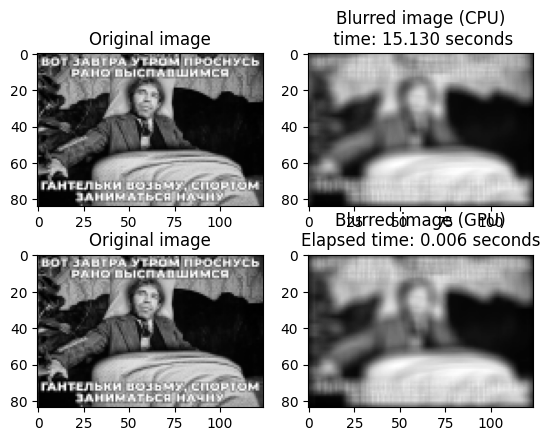

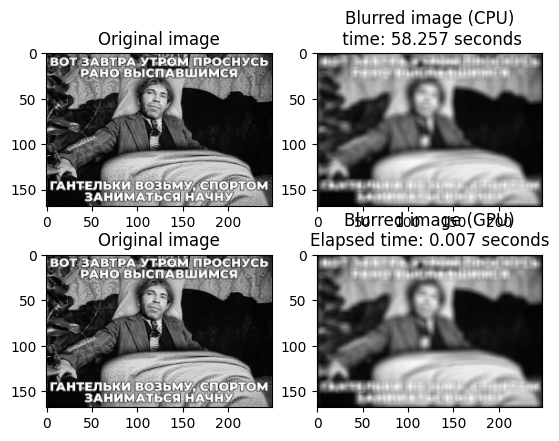

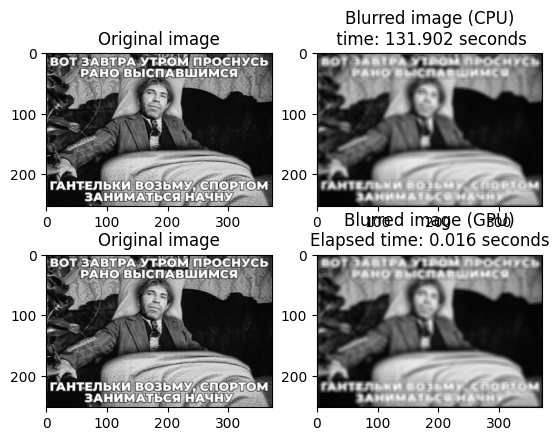

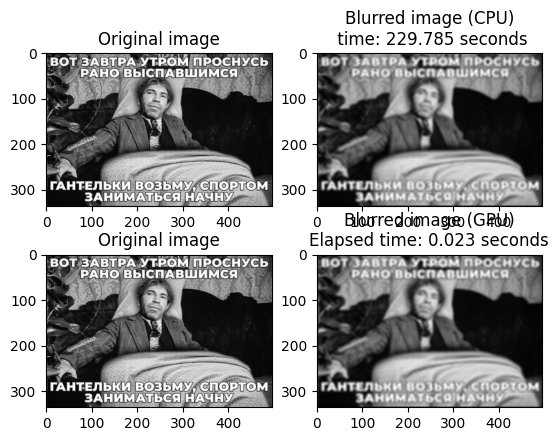

In [26]:
import os
import cv2
from matplotlib import pyplot as plt


if __name__ == "__main__":
    image_path = "picture.bmp"
    times_cpu = []
    sizes = []
    times_gpu = []

    import cv2
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    for i in range(1, 5):
      scale_percent = 20*i
      height, width = img.shape[0], img.shape[1]
      height = int(height * scale_percent / 100)
      width = int(width * scale_percent / 100)

      dim = (width, height)

      original_image = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

      height, width = original_image.shape
      sizes.append([height, width])

      cpu = CPU_function()
      blurred_image, processing_time = cpu.get_blurred_image(
          original_image
      )
      times_cpu.append(processing_time)

      plt.subplot(2, 2, 1)
      plt.imshow(original_image, cmap="gray")
      plt.title("Original image")

      plt.subplot(2, 2, 2)
      plt.imshow(blurred_image, cmap="gray")
      plt.title(f"Blurred image (CPU)\n time: {processing_time:0.3f} seconds")

      gpu = GPU()
      blurred_image, processing_time = gpu.get_blurred_image(
          original_image
      )
      times_gpu.append(processing_time)
      plt.subplot(2, 2, 3)
      plt.imshow(original_image, cmap="gray")
      plt.title("Original image")

      plt.subplot(2, 2, 4)
      plt.imshow(blurred_image, cmap="gray")
      plt.title(f"Blurred image (GPU)\nElapsed time: {processing_time:0.3f} seconds")

      plt.show()

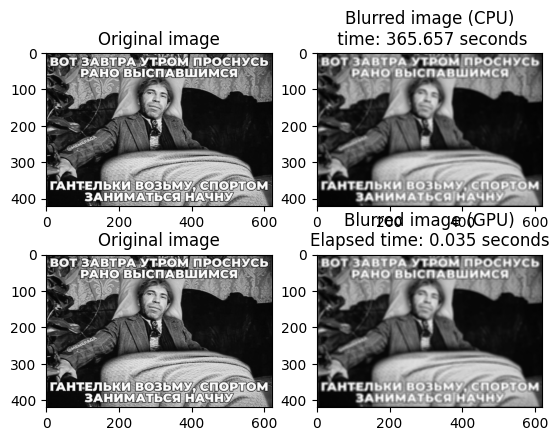

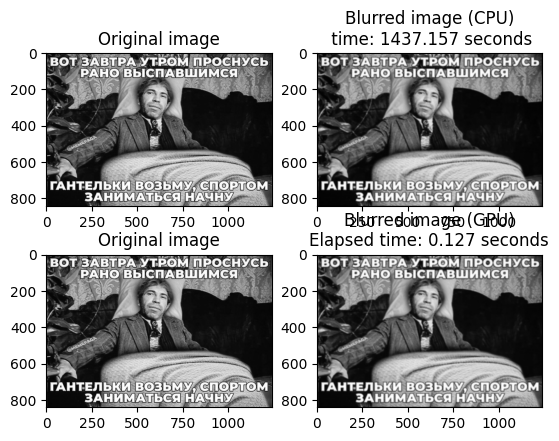

In [51]:
# times_cpu = [15.129733085632324, 58.25700068473816, 131.90193915367126, 229.7848677635193, 365.6569457054138, 1437.1565396785736]
# sizes = [[84, 124], [168, 248], [252, 372], [336, 496], [420, 620], [840, 1240]]
# times_gpu = [0.0062901973724365234, 0.007061004638671875, 0.01619577407836914, 0.022997140884399414, 0.03518986701965332, 0.12715840339660645]

In [42]:
import math

def diag_size(sizes):
  diag = []
  for matrix in sizes:
    row = matrix[0]
    column = matrix[1]
    diag.append(math.sqrt(row*row + column*column))
  return diag


In [47]:
diag = diag_size(sizes)

84 124
168 248
252 372
336 496
420 620
840 1240


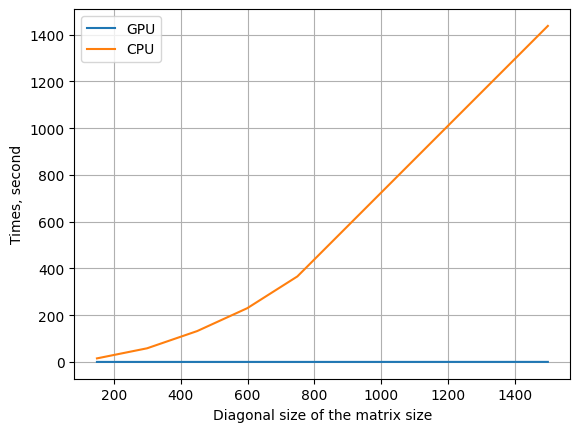

In [50]:
import matplotlib.pyplot as plt

plt.plot(diag, times_gpu, label = 'GPU')
plt.plot(diag, times_cpu, label = 'CPU')
plt.xlabel("Diagonal size of the matrix size")
plt.ylabel("Times, second")
plt.legend()
plt.grid()
plt.show()